In [17]:
import pandas as pd
import numpy as np
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
df_history_action = pd.read_pickle('./temp/action_history.plk')
df_feature = pd.read_pickle('./temp/base_feature.plk')
df_courier = pd.read_pickle('./temp/courier.plk')
df_order = pd.read_pickle('./temp/order.plk')
df_distance = pd.read_pickle('./temp/distance.plk')

In [3]:
train_path = './raw_data/eleme_round1_train_20200313'
test_path = './raw_data/eleme_round1_testA_20200313'
testB_path = './raw_data/eleme_round1_testB_20200413'

In [28]:
courier_list = []
# courier 数据
for f in os.listdir(os.path.join(train_path, 'courier')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(train_path, 'courier', f))
    df['date'] = date
    df['type'] = 'train'
    courier_list.append(df)

for f in os.listdir(os.path.join(test_path, 'courier')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(test_path, 'courier', f))
    df['date'] = date
    df['type'] = 'testA'
    courier_list.append(df)

for f in os.listdir(os.path.join(testB_path, 'courier')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(testB_path, 'courier', f))
    df['date'] = date
    df['type'] = 'testB'
    courier_list.append(df)

df_courier = pd.concat(courier_list, sort=False)
df_courier.to_pickle('./temp/courier.plk')

In [29]:
order_list = []
# order 数据
for f in os.listdir(os.path.join(train_path, 'order')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(train_path, 'order', f))
    df['date'] = date
    df['type'] = 'train'
    order_list.append(df)

for f in os.listdir(os.path.join(test_path, 'order')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(test_path, 'order', f))
    df['date'] = date
    df['type'] = 'testA'
    order_list.append(df)

for f in os.listdir(os.path.join(testB_path, 'order')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(testB_path, 'order', f))
    df['date'] = date
    df['type'] = 'testB'
    order_list.append(df)

df_order = pd.concat(order_list, sort=False)
df_order.to_pickle('./temp/order.plk')

In [30]:
distance_list = []
# distance 数据
for f in os.listdir(os.path.join(train_path, 'distance')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(train_path, 'distance', f))
    df['date'] = date
    df['type'] = 'train'
    distance_list.append(df)

for f in os.listdir(os.path.join(test_path, 'distance')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(test_path, 'distance', f))
    df['date'] = date
    df['type'] = 'testA'
    distance_list.append(df)

for f in os.listdir(os.path.join(testB_path, 'distance')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(testB_path, 'distance', f))
    df['date'] = date
    df['type'] = 'testB'
    distance_list.append(df)

df_distance = pd.concat(distance_list, sort=False)
df_distance['group'] = df_distance['date'].astype(
    'str') + df_distance['courier_id'].astype('str') + df_distance['wave_index'].astype('str')
df_distance.to_pickle('./temp/distance.plk')

In [ ]:
df_actions = []
for f in os.listdir(os.path.join(train_path, 'action')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(train_path, 'action', f))
    df['date'] = date
    df['type'] = 'train'
    df_actions.append(df)

for f in os.listdir(os.path.join(test_path, 'action')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(test_path, 'action', f))
    df['date'] = date
    df['type'] = 'testA'
    df_actions.append(df)

for f in os.listdir(os.path.join(testB_path, 'action')):
    date = f.split('.')[0].split('_')[1]
    df = pd.read_csv(os.path.join(testB_path, 'action', f))
    df['date'] = date
    df['type'] = 'testB'
    df_actions.append(df)

In [23]:
ratio = 0.5

def read_feat(df):
    label_list = []
    history_list = []
    type = df['type'].values[0]

    # 划分数据集
    groups = df.groupby(['courier_id', 'wave_index'])
    for name, group in tqdm(groups):
        if type == 'train':
            if group.shape[0]==4:
                label_data = group.tail(int(group.shape[0]-1))
                history_data = group.drop(label_data.index)
            else:
                label_data = group.tail(int(group.shape[0] * ratio))
                history_data = group.drop(label_data.index)

            # 第一个数据为正样本，其余为负样本
            label_data['target'] = 0
            label_data.reset_index(drop=True, inplace=True)
            label_data.loc[0, 'target'] = 1
            label_list.append(label_data)
            history_list.append(history_data)
        else:
            label_data = group[group['expect_time'] == 0]
            history_data = group.drop(label_data.index)

            label_data['target'] = None
            label_list.append(label_data)
            history_list.append(history_data)

    return pd.concat(label_list, sort=False), pd.concat(history_list, sort=False)

In [24]:
res = Parallel(n_jobs=12)(delayed(read_feat)(df) for df in tqdm(df_actions))
df_feature = [item[0] for item in res]
df_history = [item[1] for item in res]

df_feature = pd.concat(df_feature, sort=False)
df_history = pd.concat(df_history, sort=False)

100%|██████████| 41/41 [00:22<00:00,  1.80it/s]


In [25]:
df_feature['group'] = df_feature['date'].astype(
    'str') + df_feature['courier_id'].astype('str') + df_feature['wave_index'].astype('str')
df_history['group'] = df_history['date'].astype(
    'str') + df_history['courier_id'].astype('str') + df_history['wave_index'].astype('str')
df_feature['target'] = df_feature['target'].astype('float')
df_feature['id'] = range(df_feature.shape[0])

In [26]:
df_history.to_pickle('./temp/action_history_f.plk')
df_feature.to_pickle('./temp/base_feature_f.plk')

In [ ]:
# sum_list=pd.DataFrame()
# for i in range(35,41):
#     a=pd.DataFrame(df_actions[i].groupby(['courier_id','wave_index']).apply(lambda x:[x['date'].values[0],sum(x['expect_time']==0),sum(x['expect_time']==0)/len(x)]).values.tolist())
#     sum_list=pd.concat([sum_list,a])
# sum_list=sum_list.sort_values([0])
# sum_list.groupby([2]).size()
# sum_list.groupby([1]).size()
# sum_list.groupby([1,2]).size()

0.5470011247199419 0.125


(array([  64.,  141.,  279.,  509., 1112.,   81., 1564.,   95.,  312.,
          36.]),
 array([0.125 , 0.2025, 0.28  , 0.3575, 0.435 , 0.5125, 0.59  , 0.6675,
        0.745 , 0.8225, 0.9   ]),
 <a list of 10 Patch objects>)

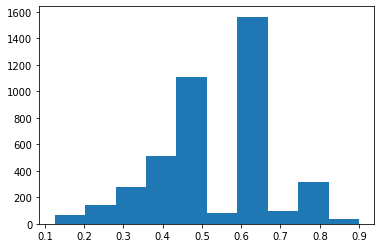

In [19]:
print(sum_list[2].mean(),sum_list[2].min())
plt.hist(sum_list[2])

4.6775578344860484 3


(array([2.698e+03, 9.780e+02, 3.220e+02, 1.260e+02, 3.200e+01, 2.200e+01,
        1.000e+01, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([ 3. ,  4.8,  6.6,  8.4, 10.2, 12. , 13.8, 15.6, 17.4, 19.2, 21. ]),
 <a list of 10 Patch objects>)

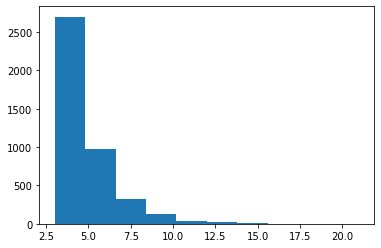

In [20]:
print(sum_list[1].mean(),sum_list[1].min())
plt.hist(sum_list[1])

In [22]:
df_order.groupby('courier_id').size()

courier_id
10007871     20
10012191     34
10012508     27
10021791     41
10037225     25
             ..
125775258    21
125779698    22
125812730    22
125864962     4
125996858    20
Length: 920, dtype: int64

In [40]:
df_feature[df_feature['type']=='testB'].groupby(['group']).size()

group
202003011000025433    5
202003011000069503    4
202003011000236981    5
202003011000766511    7
202003011000766513    4
                     ..
202003061249814090    5
202003061251023610    4
202003061251191690    5
202003061255524980    6
202003061257752580    6
Length: 4193, dtype: int64

In [38]:
df_feature.groupby('group')['type'].first()

group
202002011000025430    train
202002011000025431    train
202002011000025432    train
202002011000026520    train
202002011000026521    train
                      ...  
202003061251552411    testA
202003061255524980    testB
202003061257752580    testB
202003061257796981    testA
202003061258127301    testA
Name: type, Length: 90945, dtype: object

(array([66922.,  5561.,  3511.,  2150.,  1501.,  1630.,   430.,   318.,
          237.,   273.]),
 array([ 3. ,  4.2,  5.4,  6.6,  7.8,  9. , 10.2, 11.4, 12.6, 13.8, 15. ]),
 <a list of 10 Patch objects>)

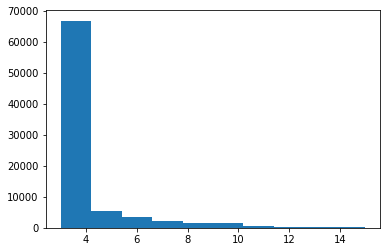

In [27]:
plt.hist(df_feature[df_feature['type']=='train'].groupby(['group']).size())

(array([2.698e+03, 9.780e+02, 3.220e+02, 1.260e+02, 3.200e+01, 2.200e+01,
        1.000e+01, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([ 3. ,  4.8,  6.6,  8.4, 10.2, 12. , 13.8, 15.6, 17.4, 19.2, 21. ]),
 <a list of 10 Patch objects>)

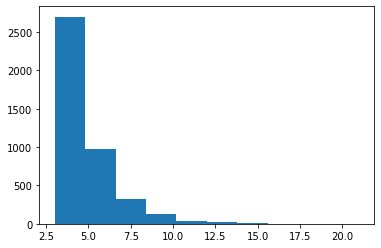

In [5]:
plt.hist(df_feature[df_feature['type']=='testB'].groupby(['group']).size())